# Analysis of multiumbrella coexsitence simulations

In [1]:
import numpy as np
import matplotlib.pylab as plt
import glob, pickle
from scipy.optimize import curve_fit
from scipy.interpolate import UnivariateSpline
from matplotlib import cm
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from matplotlib.ticker import MaxNLocator, AutoLocator

import matplotlib as mpl

import scipy.interpolate
import json
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12
plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
%config InlineBackend.figure_format = 'retina'
!mkdir -p figures


### Shared settings for analysis

In [2]:
dpl=0.05 # Lower probability range for strict histogram
dph=0.05 # Upper probability range for strict histogram
dh=2     # Bin size used for histogram
NIGNORE_STANDARD=1500 # Ignore the first 1500 frames
atm_to_gpa=0.000101325

### Plotting settings specific to the Ice-Liquid interface

In [3]:
with open('AnalysisSettings.json') as json_file:
    settings = json.load(json_file)
print(settings)

{'singlePressure': '4000.0atm', 'singleTemperature': '265.0K', 'n_temps': 5, 'n_press': 3, 'nmpi': 4, 'fig1_size': [12, 7], 'fig2_size': [7, 5], 'IGNORE': [], 'plotRef': [['tip4p/ice/FE', '../../ReferenceData/tip4p_ice_liquid_FE.dat', 9.86923], ['tip4p/ice/DE', '../../ReferenceData/tip4p_iceIh+III_liquid_DC.dat', 986.923], ['Exp', '../../ReferenceData/exp_pd.dat', 9.86923]]}


### Load data

In [4]:
def read_colvar_dict(fn):   
    # Determine fields
    with open(fn,'r') as fp:
        top = fp.readline()
        fields= top.split()[2:]
    
    # Load data columns
    data=np.genfromtxt(fn)
    
    # Create dictionary
    ret = dict()
    for i, field in enumerate(fields):
        ret[field]=data[:,i]
    ret['time_ns']=data[:,0]/1E3 
    
    ret['NIGNORE']=NIGNORE_STANDARD
    return ret

In [5]:
sims=dict()

for fold in glob.glob('COEX_*/*K/'):
    print(fold)
    sims[fold] = dict()
    try:
        colvar_files = glob.glob(fold+'COLVAR') + glob.glob(fold+'COLVAR.[0-9]')
        sims[fold]['COLVAR'] = [read_colvar_dict(fn) for fn in colvar_files]
        sims[fold]['DELTAFS'] = np.genfromtxt(fold+'DELTAFS')
        with open(fold+'DELTAFS', 'r')as fp:
            line=fp.readline()
            
        sims[fold]['DELTAFS_N_ICE'] =np.array([int(n.strip('DeltaF_')) for n in line.split()[4:]])

        sims[fold]['T'] = float(fold.split('/')[-2].strip('K'))
        sims[fold]['P'] = float(fold.split('/')[-3].replace('COEX_','').strip('atm'))
    except:
        sims.pop(fold)
        pass
with open('coex.pickle', 'wb') as handle:
    pickle.dump(sims, handle, protocol=pickle.HIGHEST_PROTOCOL)

COEX_8000.0atm/260.0K/
COEX_8000.0atm/275.0K/
COEX_8000.0atm/270.0K/
COEX_8000.0atm/265.0K/
COEX_8000.0atm/255.0K/
COEX_4000.0atm/255.0K/
COEX_4000.0atm/250.0K/
COEX_4000.0atm/260.0K/
COEX_4000.0atm/265.0K/
COEX_4000.0atm/270.0K/
COEX_2000.0atm/260.0K/
COEX_2000.0atm/270.0K/
COEX_2000.0atm/265.0K/
COEX_2000.0atm/255.0K/
COEX_2000.0atm/250.0K/
COEX_6000.0atm/255.0K/
COEX_6000.0atm/265.0K/
COEX_6000.0atm/270.0K/
COEX_6000.0atm/275.0K/
COEX_6000.0atm/260.0K/


In [6]:
with open('coex.pickle', 'rb') as handle:
    sims = pickle.load(handle)

### Set number of simulations 

In [7]:
press=np.unique([k.split('/')[0] for k in sims.keys()])
n_pressures=len(press) # Number of pressures
n_temps=int(np.ceil(len(sims)/n_pressures)) # Number of temperatures simulated

## Analysis for all pressures

### Time evolution of all collective variables

In [8]:
for key in sims.keys():
    sims[key]['NIGNORE']=NIGNORE_STANDARD
for ign in settings['IGNORE']:
    sims[ign[0]]['NIGNORE']=ign[1]
for key in sims.keys():
    if sum([len(sims[key]['COLVAR'][mpi]['refcv2.morethan'])>sims[key]['NIGNORE'] for mpi in range(settings['nmpi'])])==0:
        sims[key]['NIGNORE']=-1

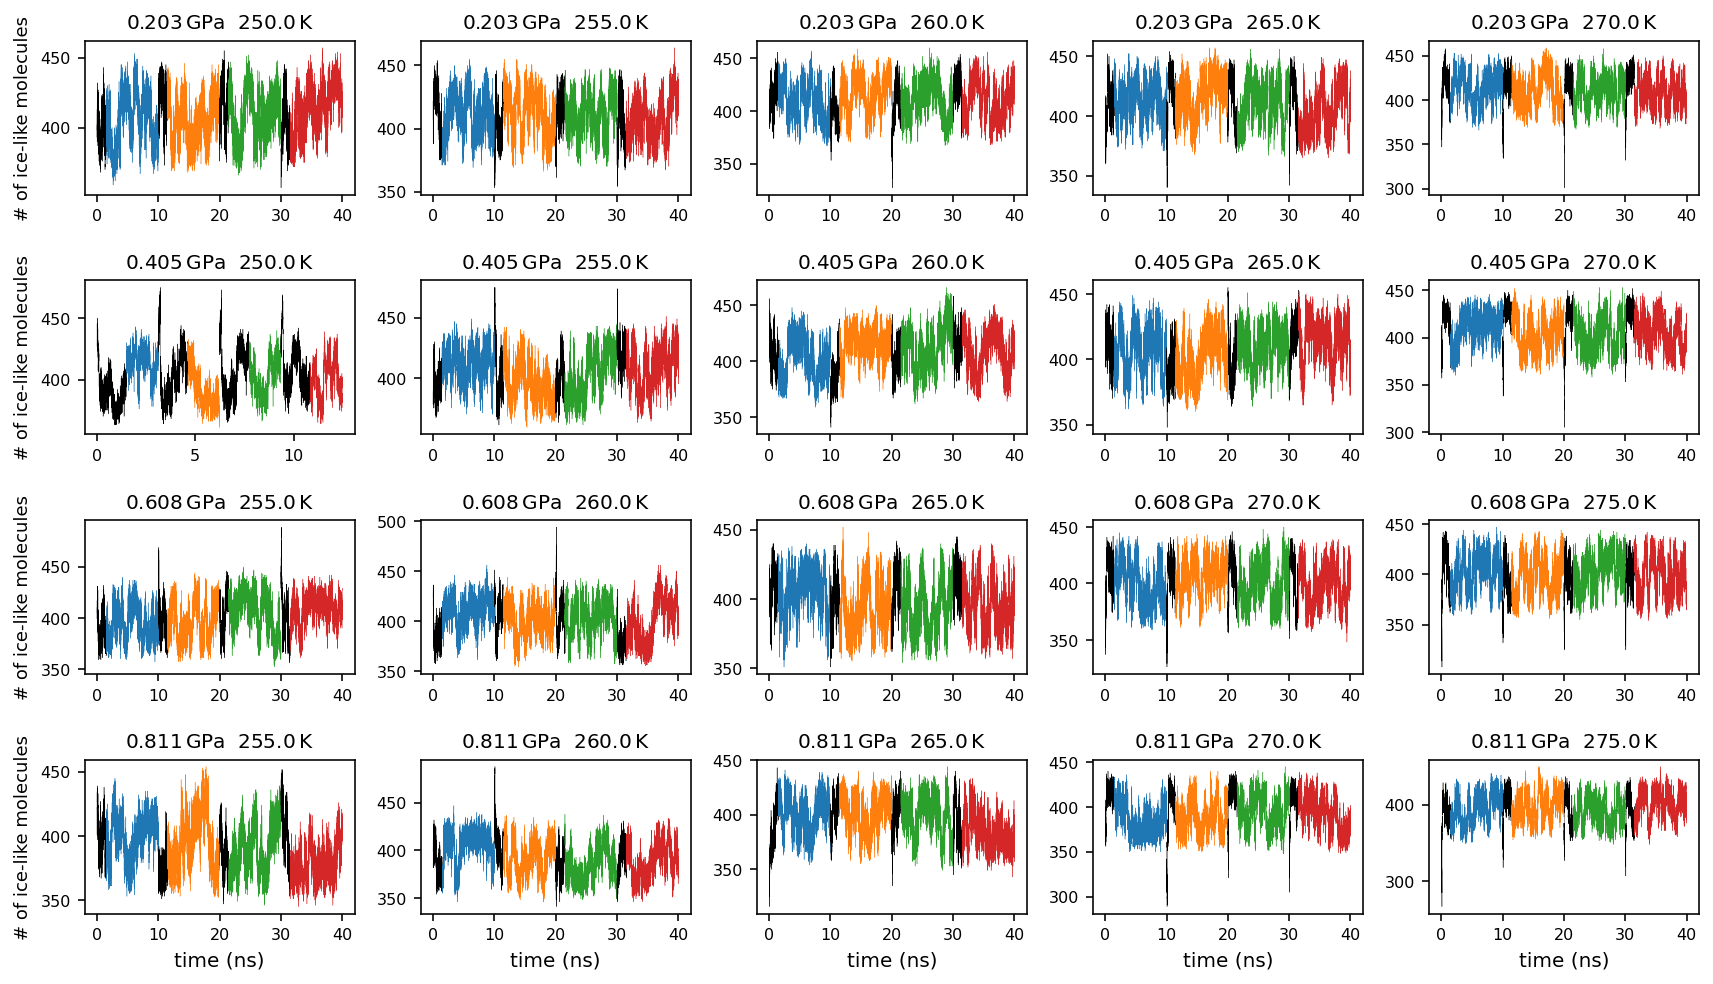

In [9]:
# Plot time evolution of collective variables
fig, axs = plt.subplots(n_pressures,n_temps,figsize=settings['fig1_size'])
axs=axs.flatten()
i=0
for  key in sorted(sims.keys()):
    if 'COLVAR' in list(sims[key].keys()):
     
        time0=0.
        for j in range(settings['nmpi']):
            colvar=sims[key]['COLVAR'][j]
            NIGNORE=sims[key]['NIGNORE']

            
            p=float(key.replace('COEX_','').split('/')[0].strip('atm'))*atm_to_gpa
            t=key.replace('COEX_','').split('/')[1].strip('K')

            #print(p,t)
            title=r'{:.3f}$\,$GPa  {}$\,$K'.format(p,t)
            axs[i].set_title(title,size = MEDIUM_SIZE)
            if sims[key]['NIGNORE']>0:
                # Part not used for fit
                axs[i].plot(time0+colvar['time_ns'][:NIGNORE],colvar['refcv2.morethan'][:NIGNORE],'k',lw=0.2)
                # Part used for fit
                axs[i].plot(time0+colvar['time_ns'][NIGNORE:],colvar['refcv2.morethan'][NIGNORE:],lw=0.2)
            else:
                # Whole simulation not used for fit
                axs[i].plot(time0+colvar['time_ns'],colvar['refcv2.morethan'],'k',lw=0.2)
            time0+=colvar['time_ns'][-1]
        
        if i%n_temps==0:
            axs[i].set_ylabel('# of ice-like molecules',fontsize=9)
        if i>=n_temps*(n_pressures-1):
            axs[i].set_xlabel('time (ns)')
            
        i+=1

        
    
plt.tight_layout()
plt.savefig('figures/time_evolution.png',dpi=300)

### Determine range for strict collective variable

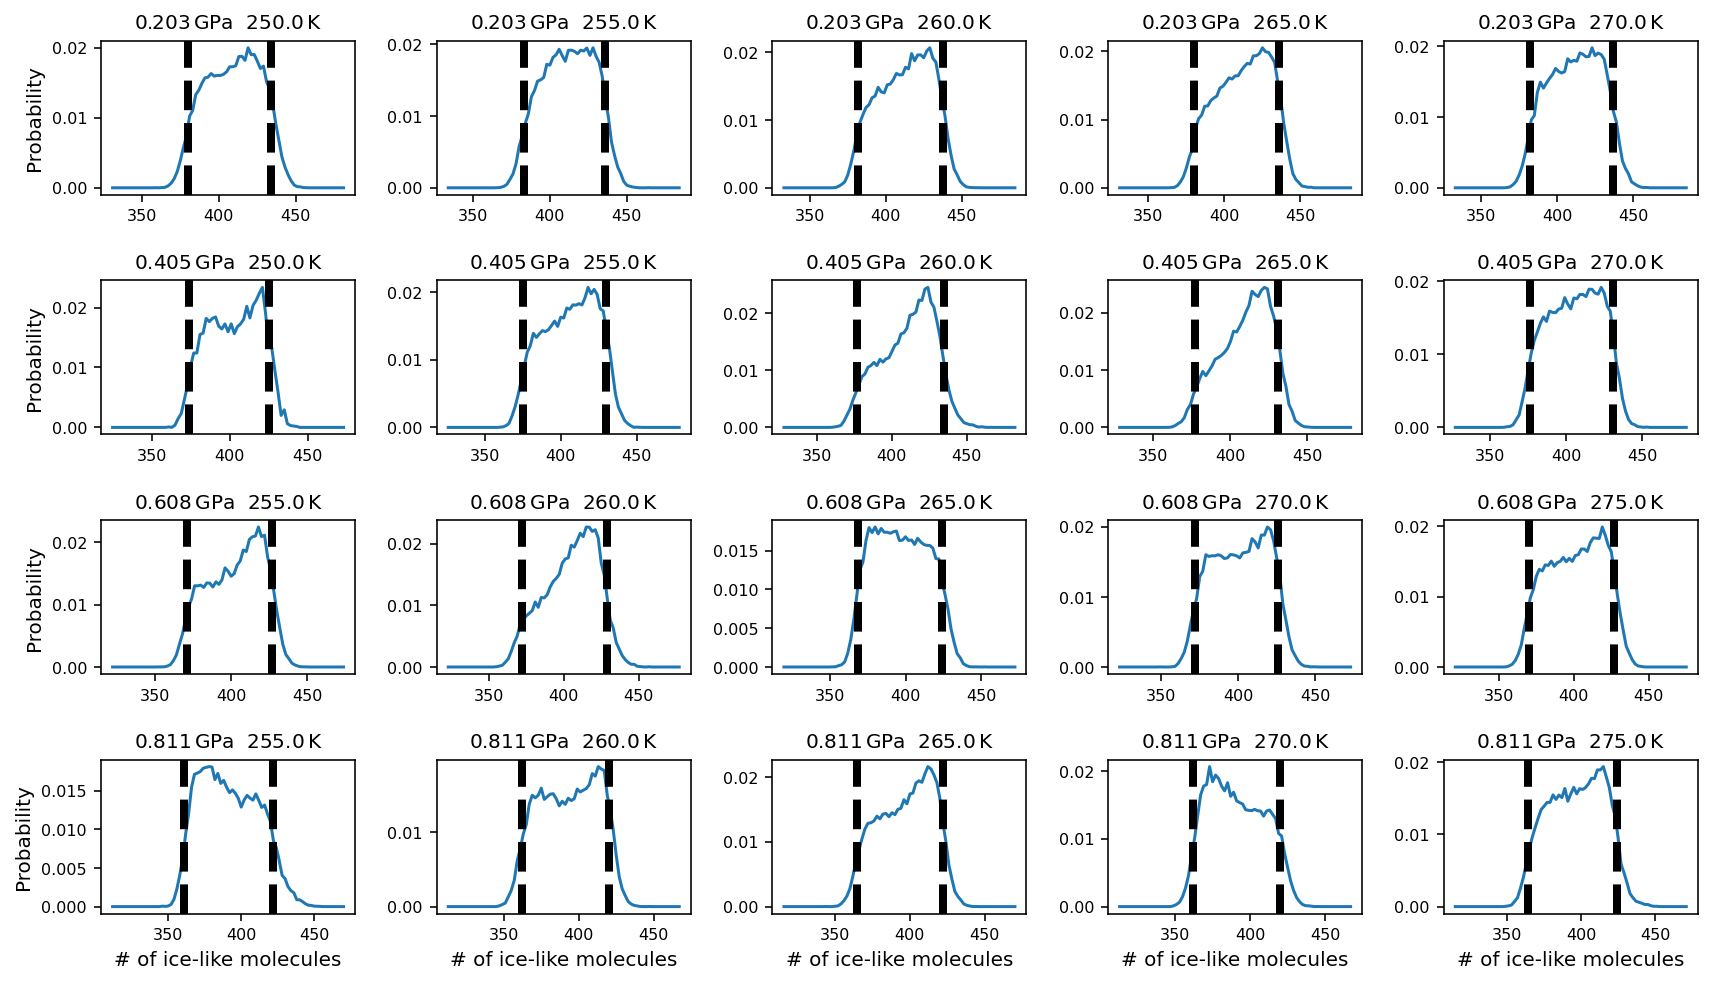

In [10]:
fig, axs = plt.subplots(n_pressures,n_temps,figsize=settings['fig1_size'])
axs=axs.flatten()
for i, key in enumerate(sorted(sims.keys())):  
    NIGNORE=sims[key]['NIGNORE']
    if NIGNORE<0:
        continue
  
    number_of_ice  = np.hstack(tuple([sims[key]['COLVAR'][mpi]['refcv2.morethan'][NIGNORE:] for mpi in range(settings['nmpi'])]))
    histo, bin_edges = np.histogram(number_of_ice,bins=1000)
    n_ice_mid=0.5*(bin_edges[1:]+bin_edges[:-1])
    
    # Determine outer range of strict collective variable histogram
    cumsum=np.cumsum(histo)
    cumsum=cumsum/cumsum.max()
    difference=np.abs(cumsum-dpl)
    ns=int(n_ice_mid[np.where(difference==difference.min())[0][0]])
    difference=np.abs(cumsum-(1-dph))
    nf=int(n_ice_mid[np.where(difference==difference.min())[0][0]])
    
    
    # Plot biased histogram
    num_ice_bins=[i for i in range(ns,nf+1)]
    bins2=[i for i in range(ns-50,nf+50)]
    sims[key]['num_ice_bins']=num_ice_bins
    histo, bin_edges = np.histogram(number_of_ice,bins=bins2[::dh],density=True)
    n_ice_mid=0.5*(bin_edges[1:]+bin_edges[:-1])
    if NIGNORE<0:
        continue
    axs[i].plot(n_ice_mid,histo)
    axs[i].axvline(x=ns,linewidth=4, color='k',ls='--')
    axs[i].axvline(x=nf,linewidth=4, color='k',ls='--')
    p=float(key.replace('COEX_','').split('/')[0].strip('atm'))*atm_to_gpa
    t=key.replace('COEX_','').split('/')[1].strip('K')

    title=r'{:.3f}$\,$GPa  {}$\,$K'.format(p,t)
    axs[i].set_title(title,size = MEDIUM_SIZE) 
    if i%n_temps==0:
        axs[i].set_ylabel('Probability')
    if i>=n_temps*(n_pressures-1):
        axs[i].set_xlabel('# of ice-like molecules')
plt.tight_layout()
plt.savefig('figures/unbiased_distributions.png',dpi=300, bbox_inches='tight')

### Estimation of chemical potential from collective variables and bias

In [11]:
def linear_fn(x, a, b):
    return a*x + b

In [12]:

sims_result = dict()
for i, key in enumerate(sorted(sims.keys())):  
    # Load data
    sim=sims[key]
    NIGNORE=sim['NIGNORE']
    NBINS=len(sim['DELTAFS'][0,2:])//4#//3
    colvar =sim['COLVAR'] 
    if NIGNORE<0:
        continue
  
    #try:
    bias_potential = np.hstack(tuple([colvar[mpi]['opes.bias'][NIGNORE:] for mpi in range(settings['nmpi'])]))
    number_of_ice  = np.hstack(tuple([colvar[mpi]['refcv2.morethan'][NIGNORE:] for mpi in range(settings['nmpi'])]))

    # Create reweighted histogram
    beta = 1./(0.00831441001626*sim['T']) # 1/(kJ/mol)
    logweights = beta*bias_potential
    logweights -= np.amax(logweights)
    bins=sim['num_ice_bins'][::dh]
    histo, bin_edges = np.histogram(number_of_ice,weights=np.exp(logweights),bins=bins)
    histo_error = np.sqrt(np.histogram(number_of_ice, bins=bins, weights=np.exp(logweights)**2)[0])
    bin_centers = (bin_edges[1:]+bin_edges[:-1])/2
    fes = -(1/beta)*np.log(histo)
    fes -= np.mean(fes)
    
    # Estimate error of bin
    fes_error = (1/beta)*histo_error/histo

    # Fit linear curve
    try:
        popt, pcov = curve_fit(linear_fn, bin_centers, fes, sigma=fes_error)
    except:
        continue
    sims_result[key]=dict()
    sims_result[key]['n_water']=bin_centers
    sims_result[key]['fes']=fes
    sims_result[key]['fes_err']=fes

    sims_result[key]['fes_linear']=linear_fn(bin_centers,*popt)
    perr = np.sqrt(np.diag(pcov))[0]
    sims_result[key]['chem_pot'] = [popt[0],perr]

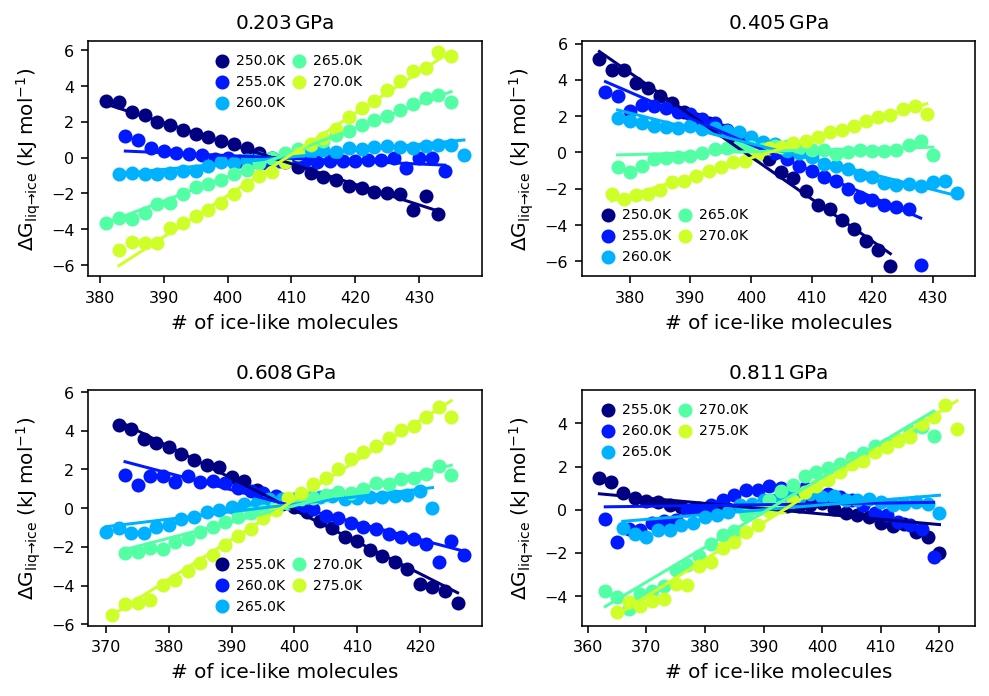

In [13]:
colors = plt.cm.jet(np.linspace(0,0.6,n_temps))
if n_pressures>2:
    fig, axs = plt.subplots(2, int(np.ceil(n_pressures/2)),figsize=settings['fig2_size'])
    axs=axs.flatten()

else:
    fig, axs = plt.subplots(1, 2,figsize=settings['fig2_size'])

press=np.unique([k.split('/')[0] for k in sims_result.keys()])
for i, p in enumerate(press):
    j=0
    for key in sims_result.keys():
        if p in key:
          
            title=r'{:.3f}$\,$GPa'.format(float(p.strip('COEX_atm'))*atm_to_gpa)
            axs[i].set_title(title,size = MEDIUM_SIZE)
            sim=sims_result[key]
            title=key.replace(p,'').strip('/')
            axs[i].scatter(sim['n_water'],sim['fes'],color=colors[j],label=title)
            axs[i].plot(sim['n_water'],sim['fes_linear'],color=colors[j])
            j+=1
    
    axs[i].set_xlabel(r'# of ice-like molecules')
    axs[i].set_ylabel(r'$\Delta$G$_{\mathrm{liq}\to \mathrm{ice}}$ (kJ mol$^{-1}$)')
    axs[i].legend(ncol=2,prop={'size': 7},handletextpad=0.0,labelspacing=0.5,columnspacing=0.0,frameon=False)

if len(axs)!=n_pressures:
    axs[i+1].axis('off')    
plt.tight_layout()

plt.savefig('figures/free_energies.png',dpi=300,bbox_inches='tight')

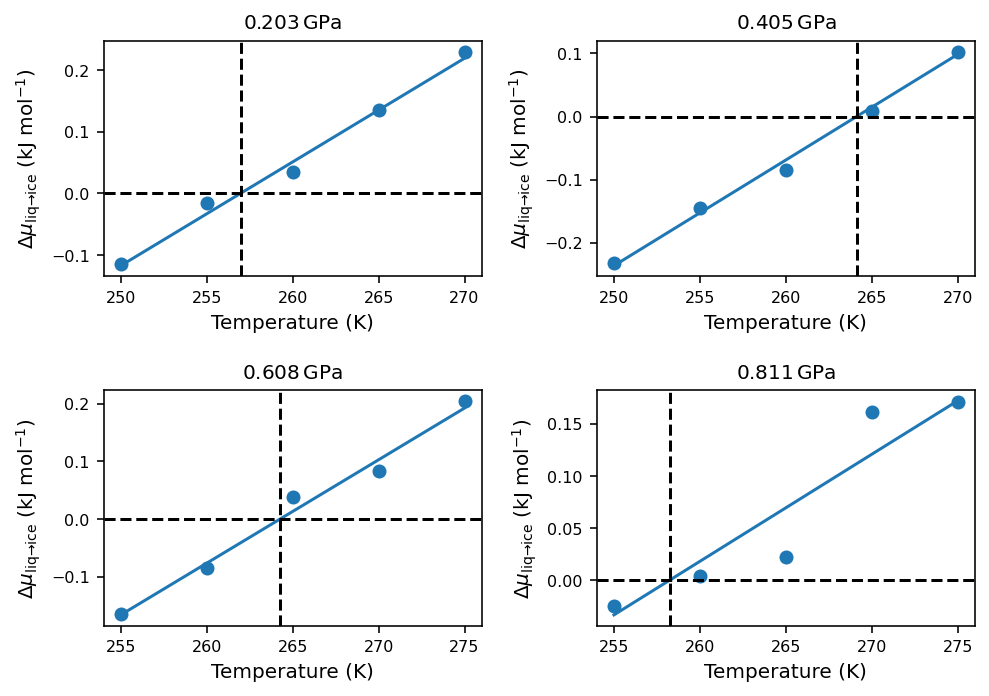

In [14]:
if n_pressures>2:
    fig, axs = plt.subplots(2, int(np.ceil(n_pressures/2)),figsize=settings['fig2_size'])
    axs=axs.flatten()
else:
    fig, axs = plt.subplots(1, 2,figsize=settings['fig2_size'])

coex_line=[]
chempots=dict()
for i, p in enumerate(press):
    j=0
    chem_pot=[]
    for key in sims_result.keys():
        if p in key:

            sim=sims_result[key]
            chem_pot.append([sims[key]['T'], sim['chem_pot'][0],sim['chem_pot'][1]])
    chem_pot = np.array(chem_pot)
    popt, pcov = curve_fit(linear_fn, chem_pot[:,0], chem_pot[:,1],sigma=chem_pot[:,2])

    axs[i].scatter(chem_pot[:,0],chem_pot[:,1])
    axs[i].plot(chem_pot[:,0],linear_fn(chem_pot[:,0],*popt))

    T_melt=-popt[1]/popt[0]
    S_melt=popt[0]
    H_melt= -popt[1]
    coex_line.append([float(p.strip('COEX_atm')),T_melt,H_melt,S_melt])
    
    key='{}'.format(p)
    chempots[key]=np.vstack((chem_pot[:,0],chem_pot[:,1],linear_fn(chem_pot[:,0],*popt))).T
    title=r'{:.3f}$\,$GPa'.format(float(p.strip('COEX_atm'))*atm_to_gpa)
    axs[i].set_title(title,size = MEDIUM_SIZE)
    axs[i].axhline(y=0.0, linestyle='--',color='k')
    axs[i].axvline(x=T_melt, linestyle='--',color='k')
    axs[i].set_ylabel(r'$\Delta\mu_{\mathrm{liq}\to \mathrm{ice}}$ (kJ mol$^{-1}$)')
    axs[i].set_xlabel('Temperature (K)')
    
coex_line=np.array(coex_line)
coex_line=coex_line[np.argsort(coex_line[:,0])]
if len(axs)!=n_pressures:
    axs[i+1].axis('off') 
plt.tight_layout()
plt.savefig('figures/chemical_potential.png',dpi=300, bbox_inches='tight')

### Store melting data

In [15]:
with open('P_T.dat','w') as fp:
    fp.write('#{:14}{:20}{:20}{:20}'.format('pressure/atm','T/K','Hfus/kJ/(mol)','Sfus/kJ/(mol K)'))
    for c in coex_line:
        fp.write('\n{:<15.0f}{:<20.1f}{:<20.1f}{:<20.5f}'.format(c[0],c[1],c[2],c[3]))
!cat P_T.dat

#pressure/atm  T/K                 Hfus/kJ/(mol)       Sfus/kJ/(mol K)     
2000           257.0               4.3                 0.01683             
4000           264.1               4.4                 0.01674             
6000           264.3               4.7                 0.01792             
8000           258.2               2.7                 0.01027             

### Plot phase diagram

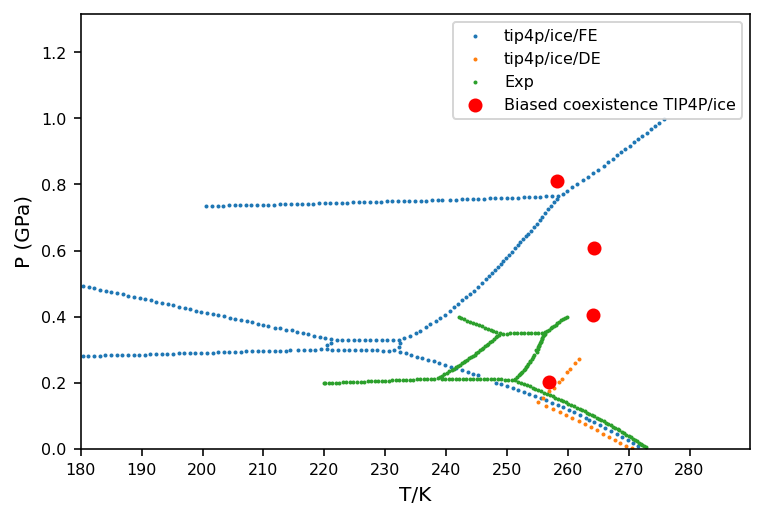

In [16]:
plt.figure()
for lines in settings['plotRef']:
    data=np.loadtxt(lines[1])
    data[:,1]*=lines[2]
    plt.scatter(data[:,0],data[:,1]*atm_to_gpa,s=1,label=lines[0])
P_T=np.loadtxt('P_T.dat')
plt.scatter(P_T[:,1],P_T[:,0]*atm_to_gpa,color='r',label='Biased coexistence TIP4P/ice')
plt.xlabel('T/K')
plt.ylabel('P (GPa)')
plt.legend()
plt.xlim([180,290])
plt.ylim([0,13000*atm_to_gpa])
a=plt.xticks(np.arange(180,290,10)) 
plt.savefig('figures/phase_diagram.png',dpi=300, bbox_inches='tight')

### Plot of final free energy profile

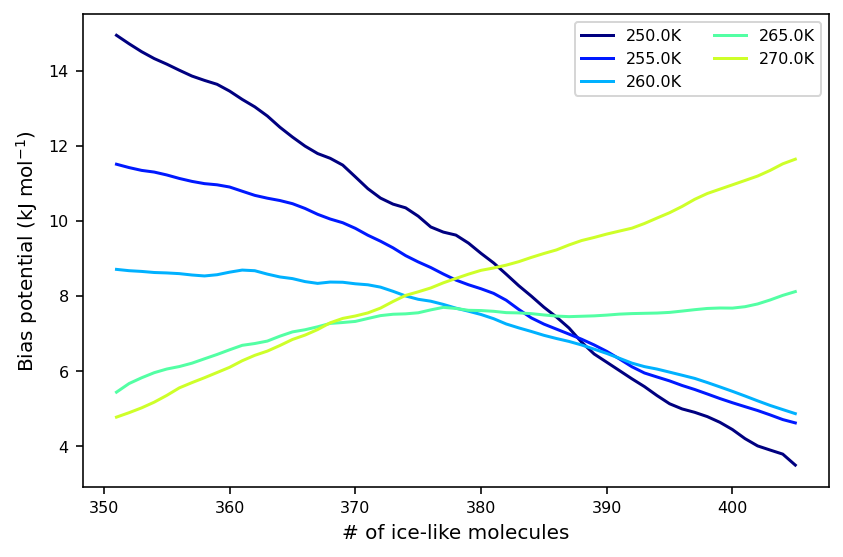

In [17]:
j=0
for i, key in enumerate(sorted(sims.keys())):  
    if settings['singlePressure'] == key.split('/')[0].strip('COEX_'):
        sim=sims[key]
        title=key.replace('COEX_'+settings['singlePressure'],'').strip('/')
        plt.plot(sims[fold]['DELTAFS_N_ICE'],sim['DELTAFS'][-1,2:],color=colors[j],label=title)
        j+=1
plt.xlabel('# of ice-like molecules')
plt.ylabel(r'Bias potential (kJ mol$^{-1}$)')
plt.legend(ncol=2)       
plt.tight_layout()
plt.savefig('figures/bias_potentials{}.png'.format(settings['singlePressure']),dpi=300, bbox_inches='tight')

## Single pressure summary

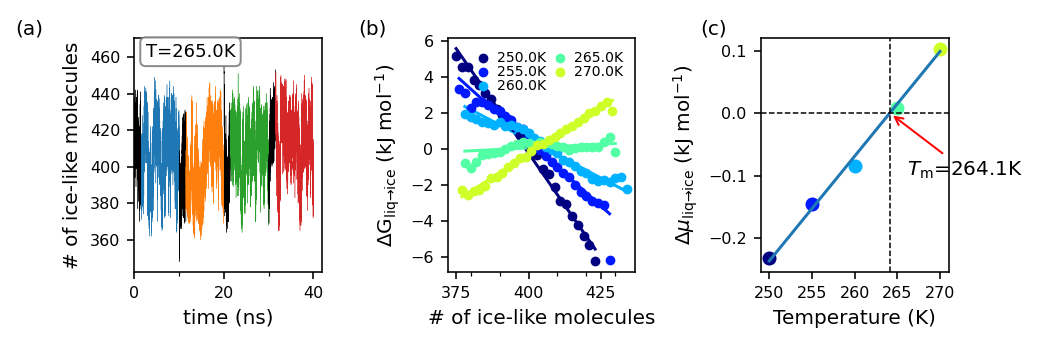

In [18]:
for i, key in enumerate(sorted(sims.keys())): 
    if settings['singlePressure'] == key.split('/')[0].strip('COEX_'):
        if settings['singleTemperature'] == key.split('/')[-2]:
            sim_PT=sims[key]
fig, axs = plt.subplots(1,3, figsize=(7.2, 2.5), facecolor='w', edgecolor='k')
axs = axs.ravel()


time0=0
# Plot time evolution
for j in range(settings['nmpi']):
    colvar=sim_PT['COLVAR'][j]
    NIGNORE=sim_PT['NIGNORE']


   # axs[i].title.set_text(key.replace('COEX_','').replace('/', ' '))
    if sims[key]['NIGNORE']>0:
        # Part not used for fit
        axs[0].plot(time0+colvar['time_ns'][:NIGNORE],colvar['refcv2.morethan'][:NIGNORE],'k',lw=0.2)
        # Part used for fit
        axs[0].plot(time0+colvar['time_ns'][NIGNORE:],colvar['refcv2.morethan'][NIGNORE:],lw=0.2)
    else:
        # Whole simulation not used for fit
        axs[0].plot(time0+colvar['time_ns'],colvar['refcv2.morethan'],'k',lw=0.2)
    time0+=colvar['time_ns'][-1]
axs[0].set_xlim(left=0)
axs[0].set_xlabel('time (ns)')
axs[0].set_ylabel('# of ice-like molecules')
axs[0].xaxis.set_minor_locator(MultipleLocator(10))
axs[0].set_ylim(top=axs[0].get_ylim()[1]+10.)
bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)
axs[0].text(axs[0].get_xlim()[0]+2.5,axs[0].get_ylim()[1]-7.5, 'T={}'.format(settings['singleTemperature']), ha="left", va="center", size=9,
        bbox=bbox_props)

#axs[0].annotate('T={}'.format(settings['singleTemperature']),xy=[0.025,0.925],xycoords='axes fraction')
# Plot free energy profiles
j=0
for i, key in enumerate(sorted(sims_result.keys())): 
    if settings['singlePressure'] == key.split('/')[0].strip('COEX_'):
        title=key.replace('COEX_'+settings['singlePressure'],'').strip('/')
        axs[1].scatter(sims_result[key]['n_water'],sims_result[key]['fes'],color=colors[j],zorder=2,s=15,label=title)
        axs[1].plot(sims_result[key]['n_water'],sims_result[key]['fes_linear'],color=colors[j],zorder=1)
        j+=1
axs[1].set_ylabel(r'$\Delta$G$_{\mathrm{liq}\to \mathrm{ice}}$ (kJ mol$^{-1}$)')
axs[1].set_xlabel('# of ice-like molecules')
axs[1].legend(ncol=2,prop={'size': 7},handletextpad=0.0,labelspacing=0.0,columnspacing=0.0,frameon=False)
axs[1].xaxis.set_minor_locator(MultipleLocator(10))

# Plot of thermodynamic potential
for key in chempots.keys():
    if settings['singlePressure'] == key.split('/')[0].strip('COEX_'):
        for j in range(len(chempots[key])):
            axs[2].scatter(chempots[key][j,0],chempots[key][j,1],color=colors[j],zorder=1)
        axs[2].plot(chempots[key][:,0],chempots[key][:,2],zorder=2)
        axs[2].axhline(y=0.0, linestyle='--',color='k',lw=0.75)
        axs[2].set_xticks(chempots[key][:,0])
        popt, pcov = curve_fit(linear_fn, chempots[key][:,0], chempots[key][:,2])
        T_melt=-popt[1]/popt[0]
        axs[2].axvline(x=T_melt, linestyle='--',color='k',lw=0.75)
        
        plt.annotate(r'$T_{{\mathrm{{m}}}}$={:.1f}K'.format(T_melt),xy=[T_melt,0],xytext=[T_melt+2.0,-0.1],arrowprops=dict(arrowstyle="->",color='r'))
axs[0].annotate('(a)',xy=(0.015,0.9),xycoords='subfigure fraction')
axs[1].annotate('(b)',xy=(0.345,0.9),xycoords='subfigure fraction')
axs[2].annotate('(c)',xy=(0.675,0.9),xycoords='subfigure fraction')

axs[2].set_ylabel(r'$\Delta\mu_{\mathrm{liq}\to \mathrm{ice}}$ (kJ mol$^{-1}$)')
axs[2].set_xlabel('Temperature (K)')
plt.tight_layout()
plt.savefig('figures/summary{}.png'.format(settings['singlePressure']),dpi=300, bbox_inches='tight')

## Free energy profile

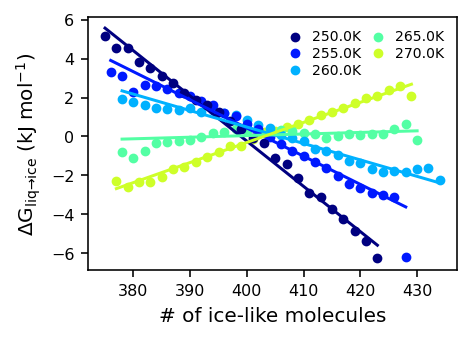

In [19]:
fig, axs = plt.subplots(1,1, figsize=(3.4, 2.5), facecolor='w', edgecolor='k')
axs = [axs]
j=0
for i, key in enumerate(sorted(sims_result.keys())): 
    if settings['singlePressure'] == key.split('/')[0].strip('COEX_'):
        title=key.replace('COEX_'+settings['singlePressure'],'').strip('/')
        plt.scatter(sims_result[key]['n_water'],sims_result[key]['fes'],color=colors[j],zorder=5-i,s=15,label=title)
        axs[0].plot(sims_result[key]['n_water'],sims_result[key]['fes_linear'],color=colors[j],zorder=1)
        j+=1
axs[0].set_ylabel(r'$\Delta$G$_{\mathrm{liq}\to \mathrm{ice}}$ (kJ mol$^{-1}$)')
axs[0].set_xlabel('# of ice-like molecules')
axs[0].legend(ncol=2,prop={'size': 7},handletextpad=0.2,labelspacing=0.2,columnspacing=0.2,frameon=False)
axs[0].xaxis.set_minor_locator(MultipleLocator(10))
plt.tight_layout()
plt.savefig('figures/free_energy_single.png'.format(settings['singlePressure']),dpi=300, bbox_inches='tight')

## Entropy of crysatlization

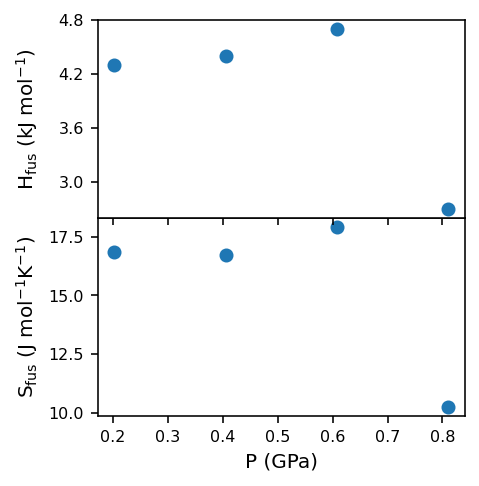

In [20]:
fig, axs = plt.subplots(2,1, figsize=(3.4, 3.25), facecolor='w', edgecolor='k')
coex_line=np.loadtxt('P_T.dat')
axs[0].scatter(coex_line[:,0]*atm_to_gpa,coex_line[:,2])
axs[1].scatter(coex_line[:,0]*atm_to_gpa,coex_line[:,3]*1000)
axs[0].set_zorder(2)
axs[0].set_ylabel(r'H$_{\mathrm{fus}}$ (kJ mol$^{-1}$)')
axs[1].set_ylabel(r'S$_{\mathrm{fus}}$ (J mol$^{-1}$K$^{-1}$)')
axs[1].set_xlabel(r'P (GPa)')
plt.tight_layout()
axs[0].tick_params(axis='x',label1On=False)
plt.subplots_adjust(top = 0.995, bottom = 0.15, right = 0.95, left = 0.2, 
            hspace = 0, wspace = 0)
fig.align_ylabels(axs[:])
axs[1].yaxis.set_major_locator(MaxNLocator(prune='upper',nbins=4))
axs[0].yaxis.set_major_locator(MaxNLocator(prune='lower',nbins=4))
plt.savefig('figures/thermodynamics.png',dpi=300, bbox_inches='tight')